In [3]:
from projToSmplx import *
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# generate data
n = 500
m = 50
T = 25
alpha = [2.**i for i in np.arange(-12,8,1)]
A = np.random.normal(0,1,(T,m,n))
b = np.random.normal(0,1,(T,m))
# A = np.array([np.random.normal(0,1, n) for i in range(m)])

## CVXPy

In [5]:
def cvx_opt(A, b):
    x = cp.Variable(n)
    objective = cp.Minimize(cp.norm(A@x - b,1))
    constraints = [x >= 0,
                   x.T @ np.ones(n) == 1]
    prob = cp.Problem(objective, constraints)
    obj_cvx = prob.solve()
    return x.value, obj_cvx

obj_cvxs = [cvx_opt(A[i,:,:], b[i,:])[1] for i in range(T)]

/home/akshay/miniconda3/envs/cvx2/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


## Mirror Descent

In [6]:
def subgrad_obj(x, A, b):
    return np.sign(A@x - b) @ A

def mirror_descent(A, b, alpha, steps =100):
    x = np.ndarray((steps+1, n))
    x[0,:] = np.zeros(n)
    for i in range(steps):
        x[i+1] = projToSmplx(x[i] - alpha*subgrad_obj(x[i], A, b))
    return x

xs = [[mirror_descent(A[i,:,:], b[i,:], a) for i in range(T)] for a in alpha] 

In [39]:
obj = np.array([[[np.linalg.norm(A[j,:,:]@xs[a][j][idx][:] - b[j,:],1) for idx in range(101)] for j in range(T)] for a in range(len(alpha))])
gaps = np.array([[obj[a, i, -1] - obj_cvxs[i] for a in range(len(alpha))] for i in range(T)])
# obj_avg = np.average(obj, axis=1)
# obj_best = obj_avg[np.argmin(obj_avg[:,-1]),:]
# mirror_bestgap = obj_best - obj_best[-1]

## Constrained Subgradient

In [71]:
def func_c1(x):
    """
    constraint -x <= 0
    """
    n = len(x)
    return np.min([-x,np.zeros(n)], axis = 0 )

def func_c2(x):
    """
    constraint x.T @ np.ones(n) == 1
    """
    return x.T @ np.ones(n) - 1

def subgrad_c1(x):
    """
    subgradient of the constraint -x <= 0
    """
    n = len(x)
    return np.sign(np.min([-x, np.zeros(n)], axis=0))

def subgrad_c2(x):
    """
    subgradient of the constraint x.T @ np.ones(n) == 1
    """
    n = len(x)
    if x.T @ np.ones(n) == 1:
        return np.zeros(n)
    else:
        return np.ones(n)

In [77]:
def constrained_subgrad(A, b, alpha, steps=100):
    x = np.ndarray((steps+1, n))
    x[0,:] = np.zeros(n)
    for i in range(steps):
        # check constraint violation
        if np.any(func_c1(x[i]) > 0):
            g = subgrad_c1(x[i])
        elif func_c2(x[i]) != 0:
            g = subgrad_c2(x[i])
        else:
            g = subgrad_obj(x[i], A[0,:,:], b[0,:])
        x[i+1,:] = x[i,:] - alpha*g
    return x

In [78]:
xs = [[constrained_subgrad(A[i,:,:], b[i,:], a) for i in range(T)] for a in alpha] 

## Plotting

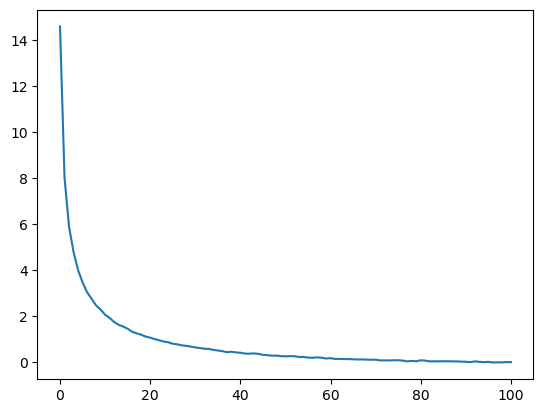

In [29]:
fig, ax = plt.subplots()
# ax.axhline(obj_cvx, label='cvxpy')
ax.plot(mirror_bestgap, label='mirror descent')